In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
from cycler import cycler

import warnings
warnings.filterwarnings('ignore')

from fredapi import Fred
fred = Fred(api_key='Enter API Key Here')
%matplotlib inline

In [2]:
def Recession_Analysis(data, data_name, normalize_move=True, normalize_days=False): 
    # data_name = str
    # normalize_move = True, 'MDD', False
    
    USREC = fred.get_series('USREC')
    USREC = pd.DataFrame(USREC,columns=['Recession'])
    USREC.index.name = 'Date'
    
    data = data.resample('M').first()
    data = data.to_period('M').to_timestamp()
    
    df_concat = pd.concat([data,USREC], axis = 1)
    df_concat = df_concat.dropna()
    
    Rec_df = df_concat[df_concat['Recession'] == 1]
    Rec_df['Rec Dates'] = Rec_df.index.copy()
    # Distinguish starting dates
    Rec_df['Rec Start'] = Rec_df['Rec Dates'] - Rec_df['Rec Dates'].shift(1) > dt.timedelta(31)
    # First obs become missing, replace with True for first starting date
    Rec_df['Rec Start'].iloc[0] = True
    # Calculate recession clusters assigned numbers starting from 1, increment=1
    Rec_df['Rec Cluster'] = Rec_df['Rec Start'].cumsum()
    
    # Total number of recessions
    cluster_num = Rec_df['Rec Cluster'].max()

    # Get Recession starting dates & put in a list
    Rec_start = Rec_df['Rec Start'][Rec_df['Rec Start'] == True]
    
    Rec_list = []
    for i in (Rec_start.index.to_period('M')):
        Rec_list.append(str(i))

    # Dictionary to store Recession segments
    d = {cluster: pd.DataFrame() for cluster in Rec_list}

    for cluster in range(cluster_num):
        # index from list + 1 matches the assigned cluster number
        d[Rec_list[cluster]] = Rec_df[Rec_df['Rec Cluster'] == cluster+1]
    
    
    # Graphing
    fig = plt.figure(figsize=(12,10))
    ax = plt.axes()
    plt.grid()

    # One color cycle color components match total cluster number
    N = cluster_num
    custom_cycler = (cycler(color = plt.cm.magma(np.linspace(0.1,0.9,N))))
    ax.set_prop_cycle(custom_cycler)
    
    # To store movement analysis per each cluster
    D = {cluster: pd.DataFrame() for cluster in Rec_list}

    for cluster in range(cluster_num):
        # get each cluster
        df = d[Rec_list[cluster]]
        # Calculate day difference after onset of recession
        df['dates'] = df.index.copy()
        df['diff'] = df['dates'] - df['dates'].shift(1)
        df['diff'] = df['diff'].dt.days
        
        # Starting month of recession, set as day 0
        df['diff'].iloc[0] = 0
        
        if normalize_days == True:
            # sets length of recession as 1 and time represent % of recession passed
            df.index = df['diff'].cumsum()/df['diff'].cumsum().iloc[-1]
        else:
            # different lengths of recession, counts days after the start of recession
            df.index = df['diff'].cumsum()

        
        # Data/Variable Movement calculation
        if normalize_move == True:
            # cumulative % movement from the base data in the starting month of recession
            df['normalized'] = (df[data_name] / df[data_name][0] - 1) * 100
        
        elif normalize_move == 'MDD':
            # MDD % within each recession cluster
            df['normalized'] = (df[data_name] / df[data_name].cummax() - 1) * 100
        
        elif normalize_move == False:
            # actually not normalized, just raw data
            df['normalized'] = df[data_name]

        # Store each cluster movements
        D[Rec_list[cluster]] = df

        # Plot normalized movements
        plt.plot(df['normalized'], label=Rec_list[cluster])
        plt.text(df.index[-1],df['normalized'].iloc[-1], Rec_list[cluster],
                 horizontalalignment='left',verticalalignment='center_baseline',color = 'blue')

    plt.axhline(0,color='black')
    plt.axvline(0,color='black')
    plt.title(f'Recession Analysis of {data_name}')
    plt.xlabel('Days after the recession started (% of recession passed if normalized)')
    plt.ylabel(f'normalized % movement (or raw movement) in {data_name}(base = {data_name} at the start of recession)')

    plt.legend()
    
    return D
    

In [4]:
# List of FRED Data
Nonfarm = fred.get_series('PAYEMS')
JO = fred.get_series('JTSJOL')
IniClaim = fred.get_series('ICSA')
CntdClaim = fred.get_series('CCSA')

FinStress = fred.get_series('STLFSI4')
Phousing = fred.get_series('CSUSHPISA')


CPI = fred.get_series('CPIAUCSL')
Stickyinfl = fred.get_series('CORESTICKM159SFRBATL')
WTI = fred.get_series('DCOILWTICO')

EFFR = fred.get_series('DFF')
FFR_target_upper = fred.get_series('DFEDTARU')
FFR_target_lower = fred.get_series('DFEDTARL')

ytm_1mo = fred.get_series('DGS1MO')
ytm_3mo = fred.get_series('DGS3MO')
ytm_6mo = fred.get_series('DGS6MO')
ytm_1y = fred.get_series('DGS1')
ytm_2y = fred.get_series('DGS2')
ytm_3y = fred.get_series('DGS3')
ytm_5y = fred.get_series('DGS5')
ytm_7y = fred.get_series('DGS7')
ytm_10y = fred.get_series('DGS10')
ytm_20y = fred.get_series('DGS20')
ytm_30y = fred.get_series('DGS30')

HYspread = fred.get_series('BAMLH0A0HYM2')
IGspread = fred.get_series('BAMLC0A0CM')
BBBspread = fred.get_series('BAMLC0A4CBBB')

# 3-Month Commercial Paper Minus Federal Funds Rate
CPFF = fred.get_series('CPFF')
# 3-Month Treasury Constant Maturity Minus Federal Funds Rate
T3MFF = fred.get_series('T3MFF')
# Moody's Seasoned Baa Corporate Bond Minus Federal Funds Rate
BAAFF = fred.get_series('BAAFF')
# Moody's Seasoned Aaa Corporate Bond Minus Federal Funds Rate
AAAFF = fred.get_series('AAAFF')
# 1-Year Treasury Constant Maturity Minus Federal Funds Rate
T1YFF = fred.get_series('T1YFF')
# 5-Year Treasury Constant Maturity Minus Federal Funds Rate
T5YFF = fred.get_series('T5YFF')
# 10-Year Treasury Constant Maturity Minus Federal Funds Rate
T10YFF = fred.get_series('T10YFF')
# 10-Year Treasury Constant Maturity Minus Federal Funds Rate Monthly
T10YFFM = fred.get_series('T10YFFM')
# 10-Year Treasury Constant Maturity Minus 2-Year Treasury Constant Maturity
T10Y2Y = fred.get_series('T10Y2Y')
# .resample('M').first().to_period('M').to_timestamp().dropna()

# 10-Year Breakeven Inflation Rate
T10YIE = fred.get_series('T10YIE')
# 5-Year Breakeven Inflation Rate
T5YIE = fred.get_series('T5YIE')
# University of Michigan: Inflation Expectation
MICH = fred.get_series('MICH')
# Labor Force Participation Rate
LFPR = fred.get_series('CIVPART')

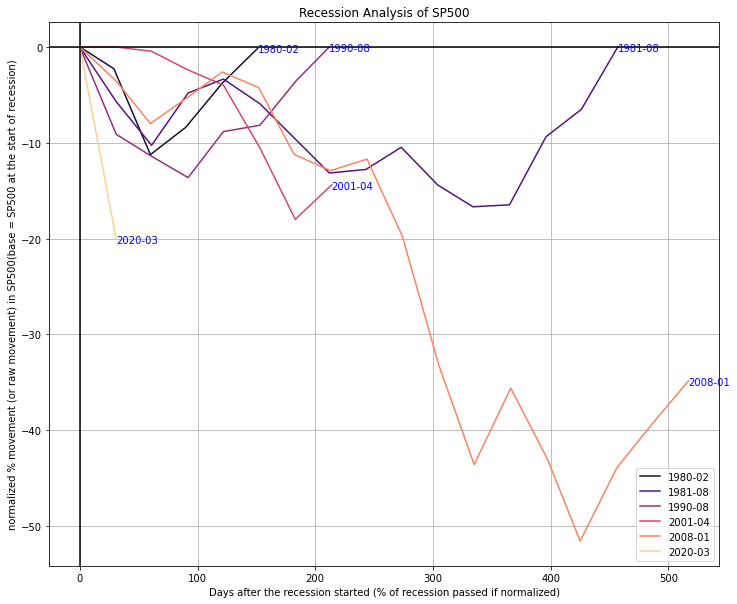

In [6]:
# S&P500
SP500 = pd.read_csv('Enter_SP500.csv_file_path')
SP500['Date'] = pd.to_datetime(SP500['Date'], format='%m/%d/%y')
SP500.sort_values(by='Date', ascending = True, inplace=True)
SP500 = SP500.set_index('Date')
SP500 = SP500[' Close']
SP500 = pd.DataFrame(SP500).rename(columns={' Close':'SP500'})

D = Recession_Analysis(SP500, 'SP500', normalize_move='MDD', normalize_days=False)

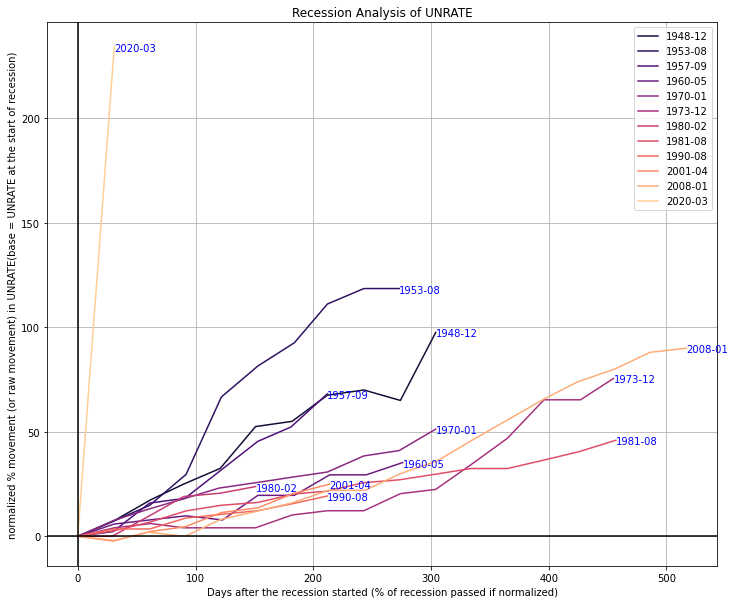

In [5]:
# Unemployment rate
UNRATE = fred.get_series('UNRATE')
UNRATE = pd.DataFrame(UNRATE).rename(columns = {0:'UNRATE'}).dropna()

D = Recession_Analysis(UNRATE, 'UNRATE', normalize_move=True, normalize_days=False)

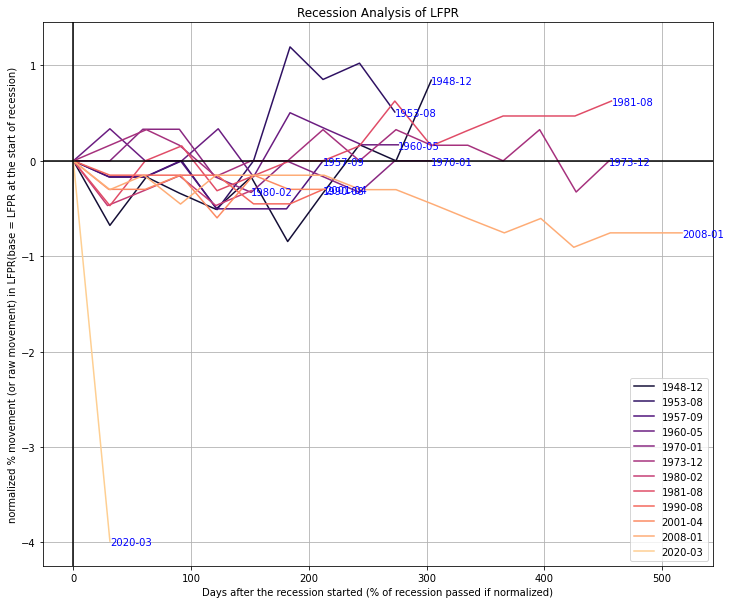

In [394]:
# Labor Force Participation Rate
LFPR = fred.get_series('CIVPART')
LFPR = pd.DataFrame(LFPR,columns=['LFPR']).dropna()

D = Recession_Analysis(LFPR, 'LFPR', normalize_move=True, normalize_days=False)

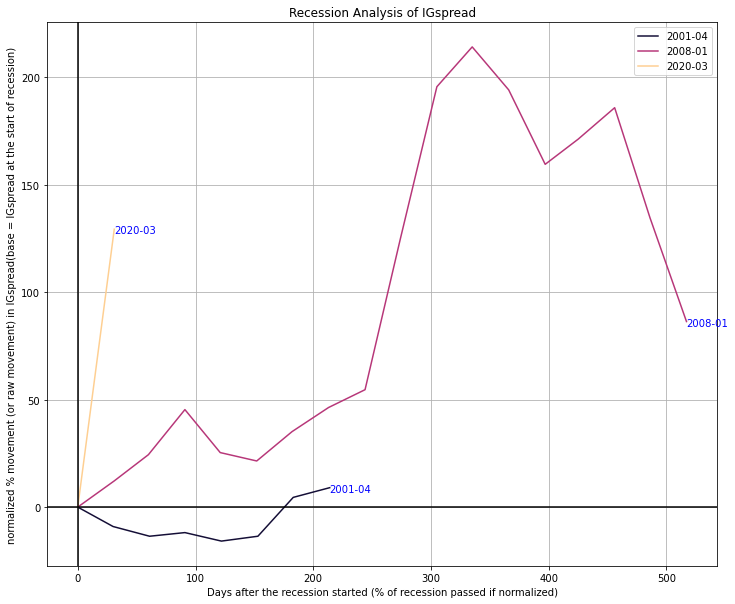

In [9]:
# Investment Grade OAS spread
IGspread = fred.get_series('BAMLC0A0CM')
IGspread = pd.DataFrame(IGspread).rename(columns = {0:'IGspread'}).dropna()

D = Recession_Analysis(IGspread, 'IGspread', normalize_move=True, normalize_days=False)

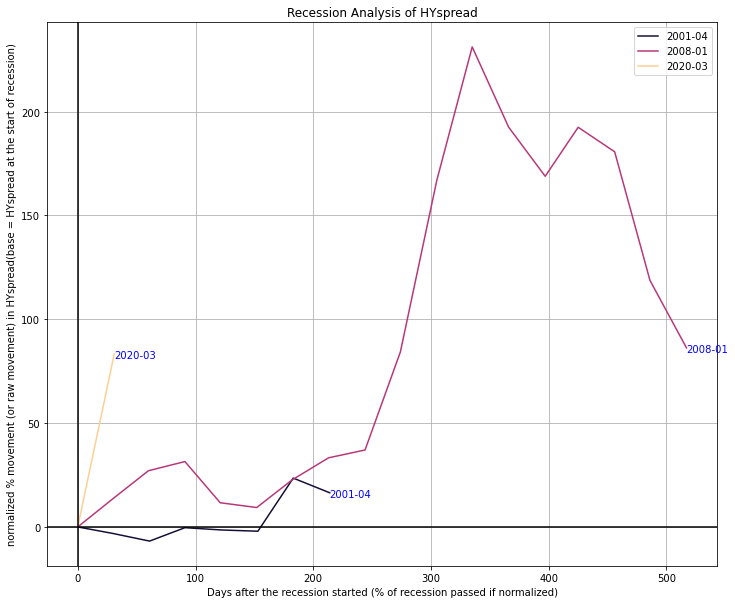

In [12]:
# High Yield OAS spread
HYspread = fred.get_series('BAMLH0A0HYM2')
HYspread = pd.DataFrame(HYspread).rename(columns = {0:'HYspread'}).dropna()

D = Recession_Analysis(HYspread, 'HYspread', normalize_move=True, normalize_days=False)

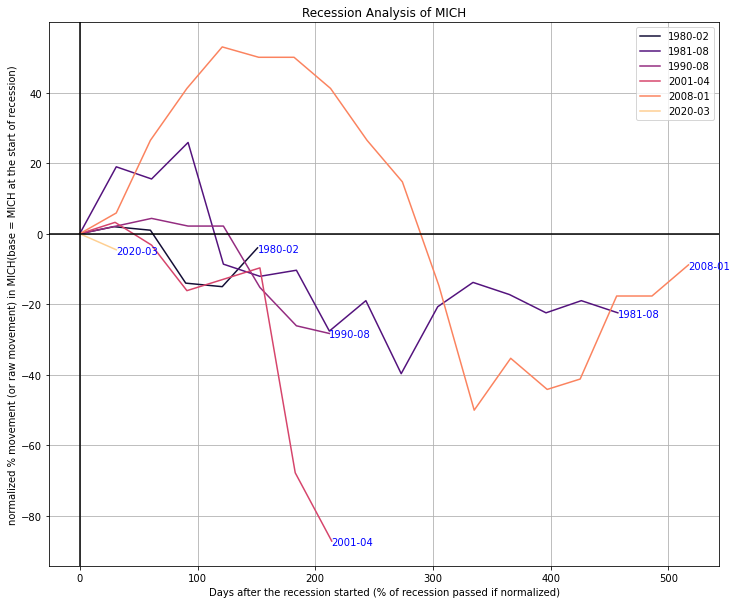

In [7]:
# UMichigan Inflation Expectations
MICH = fred.get_series('MICH')
MICH = pd.DataFrame(MICH,columns=['MICH']).dropna()

D = Recession_Analysis(MICH, 'MICH', normalize_move=True, normalize_days=False)

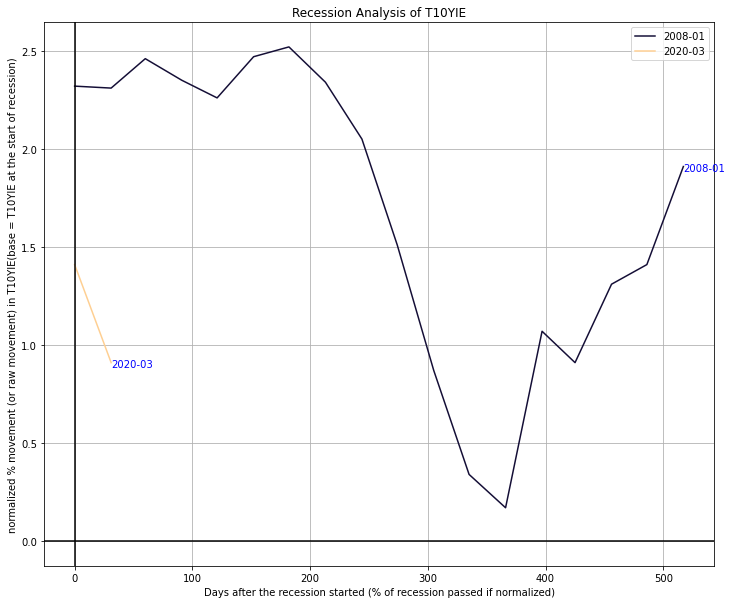

In [8]:
# 10Y Break-even inflation expectations
T10YIE = fred.get_series('T10YIE')
T10YIE = pd.DataFrame(T10YIE,columns=['T10YIE']).dropna()

D = Recession_Analysis(T10YIE, 'T10YIE', normalize_move=False, normalize_days=False)

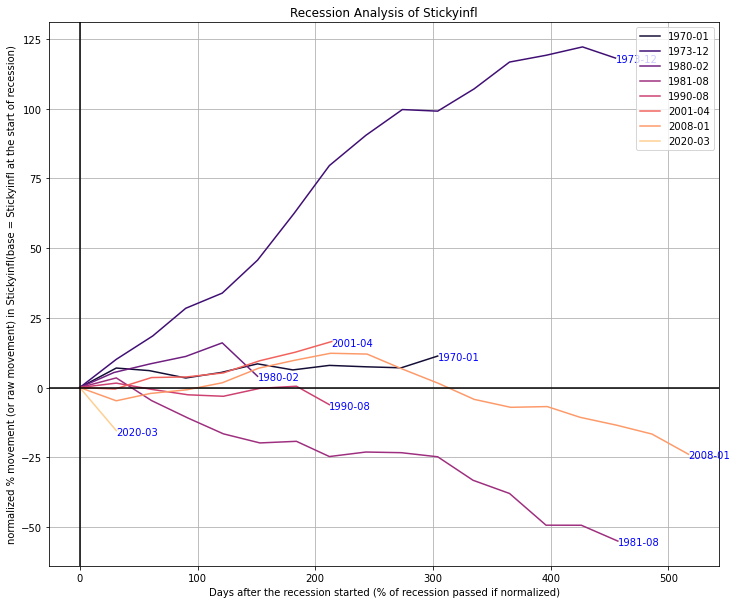

In [381]:
# Sticky inflation rate
Stickyinfl = fred.get_series('CORESTICKM159SFRBATL')
Stickyinfl = pd.DataFrame(Stickyinfl,columns=['Stickyinfl']).dropna()

D = Recession_Analysis(Stickyinfl, 'Stickyinfl', normalize_move=True, normalize_days=False)

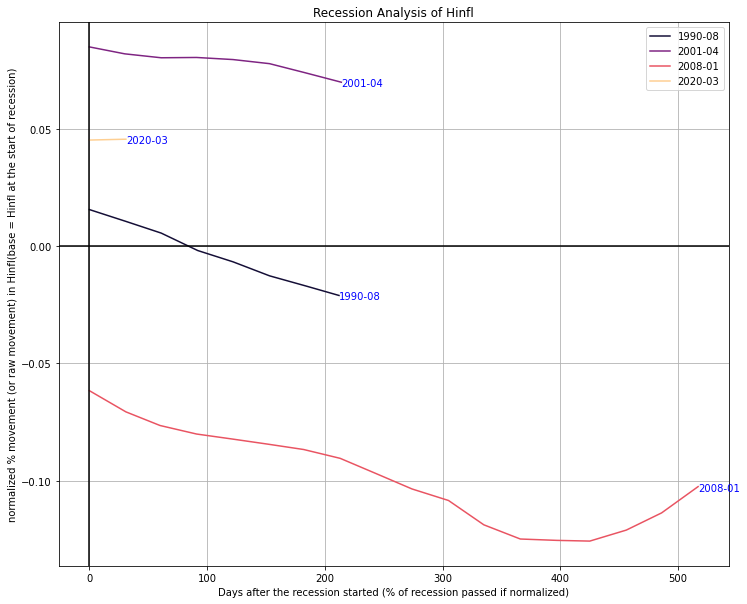

In [376]:
# Housing Price Index
Phousing = fred.get_series('CSUSHPISA')
Hinfl = Phousing/Phousing.shift(12) - 1
Hinfl = pd.DataFrame(Hinfl,columns=['Hinfl']).dropna()

D = Recession_Analysis(Hinfl, 'Hinfl', normalize_move=False, normalize_days=False)

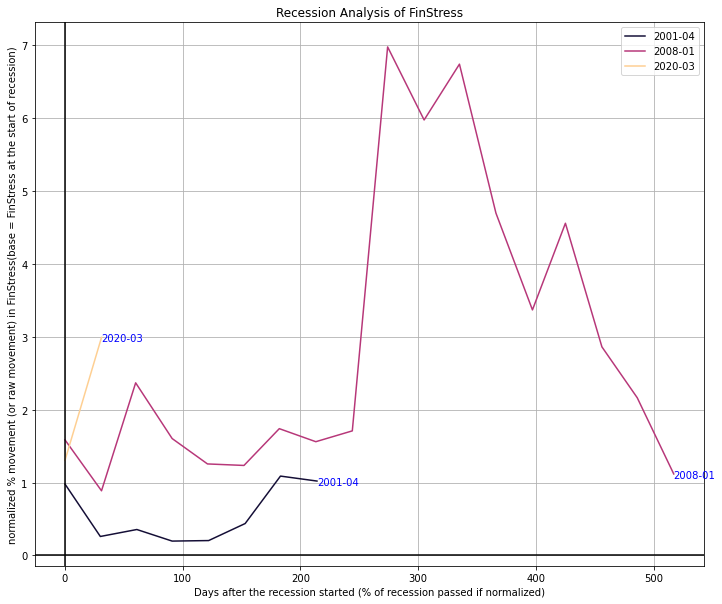

In [371]:
# Financial Stress Index
FinStress = fred.get_series('STLFSI4')
FinStress = pd.DataFrame(FinStress,columns=['FinStress']).dropna()

D = Recession_Analysis(FinStress, 'FinStress', normalize_move=False, normalize_days=False)

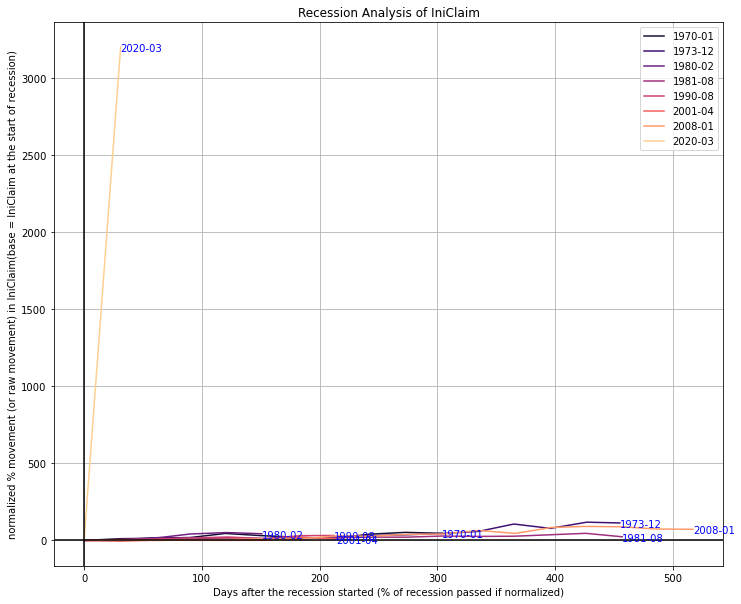

In [368]:
# Initial Jobless Claims
IniClaim = fred.get_series('ICSA')
IniClaim = pd.DataFrame(IniClaim,columns=['IniClaim']).dropna()

D = Recession_Analysis(IniClaim, 'IniClaim', normalize_move=True, normalize_days=False)

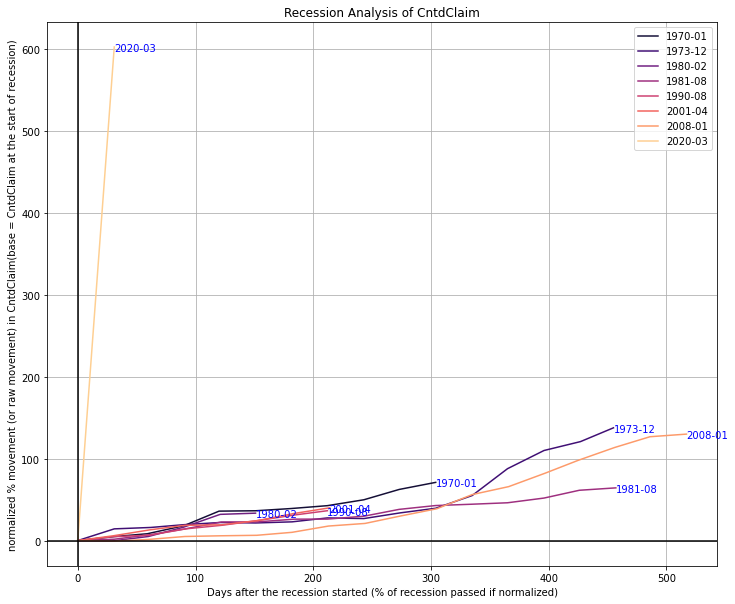

In [369]:
# Continued Jobless Claims
CntdClaim = fred.get_series('CCSA')
CntdClaim = pd.DataFrame(CntdClaim,columns=['CntdClaim']).dropna()

D = Recession_Analysis(CntdClaim, 'CntdClaim', normalize_move=True, normalize_days=False)

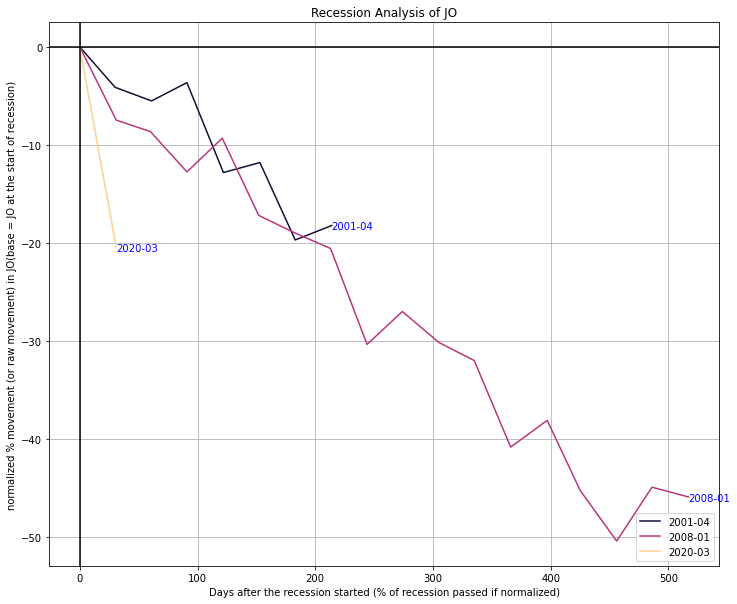

In [350]:
# Job Opennings
JO = fred.get_series('JTSJOL')
JO = pd.DataFrame(JO,columns=['JO']).dropna()

D = Recession_Analysis(JO, 'JO', normalize_move=True, normalize_days=False)

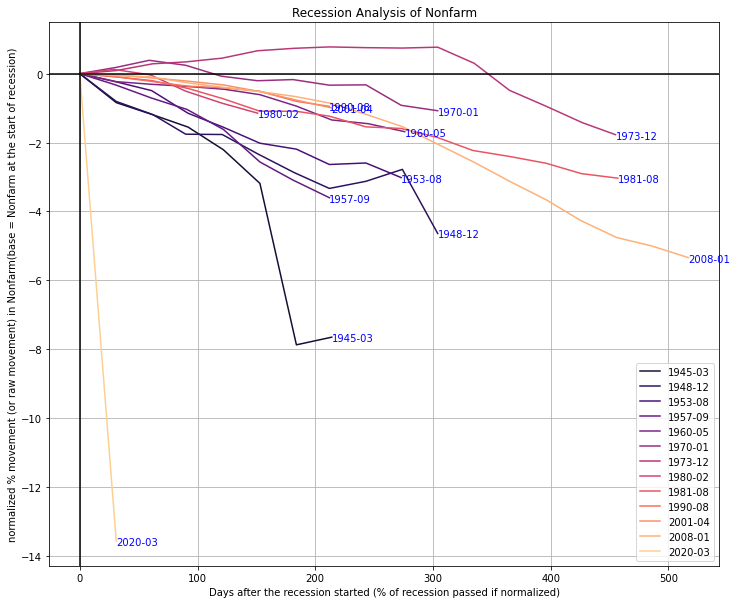

In [347]:
# Nonfarm Payrolls
Nonfarm = fred.get_series('PAYEMS')
Nonfarm = pd.DataFrame(Nonfarm,columns=['Nonfarm']).dropna()

D = Recession_Analysis(Nonfarm, 'Nonfarm', normalize_move=True, normalize_days=False)

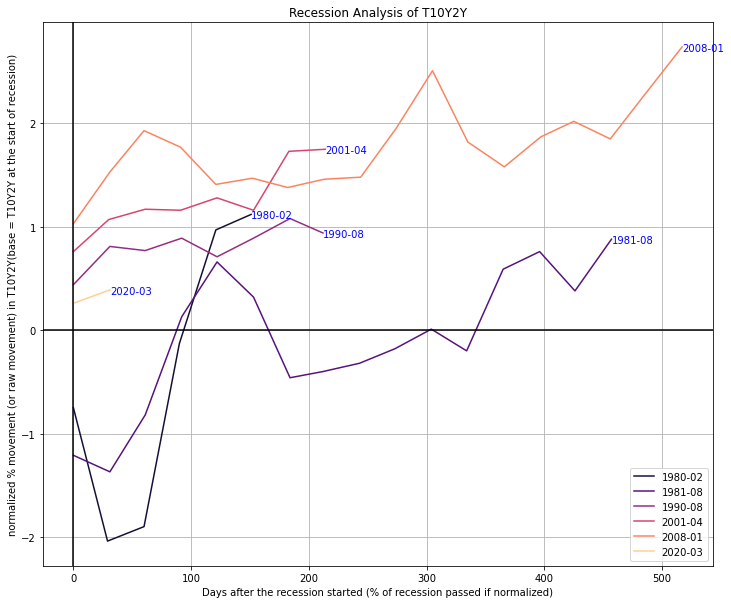

In [343]:
# 10Y - 2Y Yield spread
T10Y2Y = fred.get_series('T10Y2Y')
T10Y2Y = pd.DataFrame(T10Y2Y,columns=['T10Y2Y']).dropna()

D = Recession_Analysis(T10Y2Y, 'T10Y2Y', normalize_move=False, normalize_days=False)

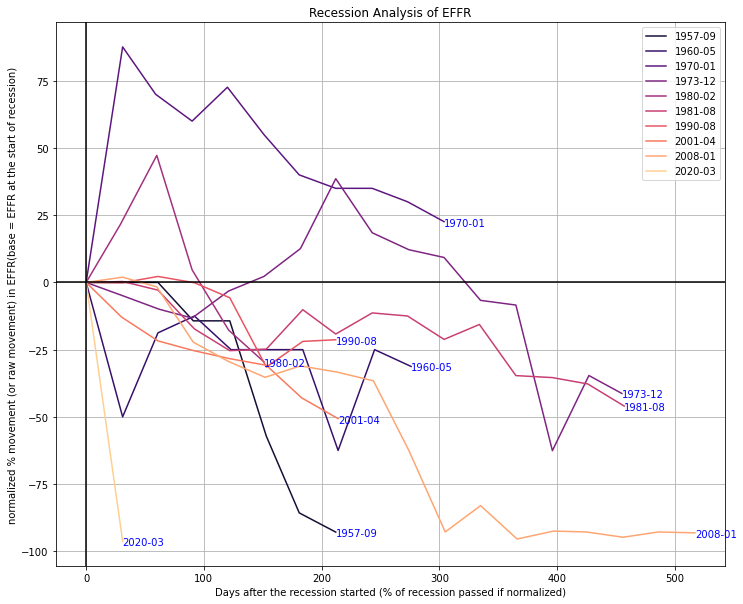

In [338]:
# Federal Funds Effective Rate
EFFR = fred.get_series('DFF')
EFFR = pd.DataFrame(EFFR,columns=['EFFR']).dropna()

D = Recession_Analysis(EFFR, 'EFFR', normalize_move=True, normalize_days=False)

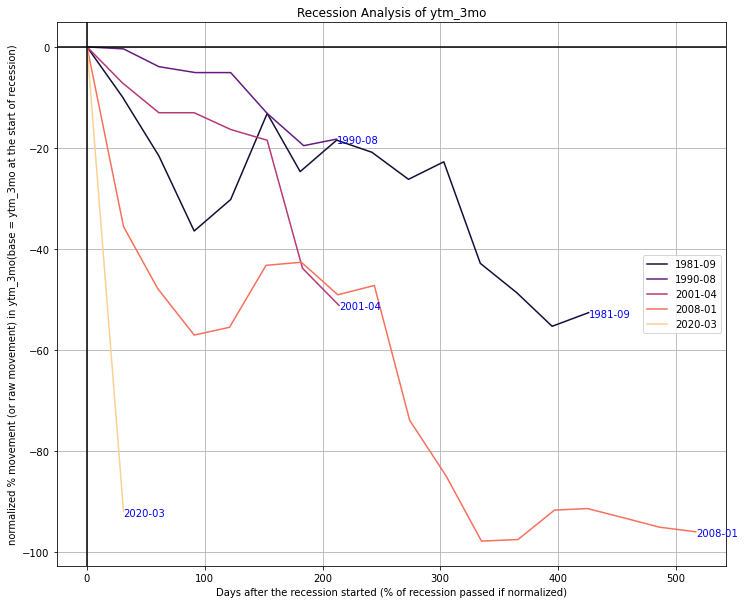

In [332]:
# 3 Months Treasury Yield
ytm_3mo = fred.get_series('DGS3MO')
ytm_3mo = pd.DataFrame(ytm_3mo,columns=['ytm_3mo']).dropna()

D = Recession_Analysis(ytm_3mo, 'ytm_3mo', normalize_move=True, normalize_days=False)

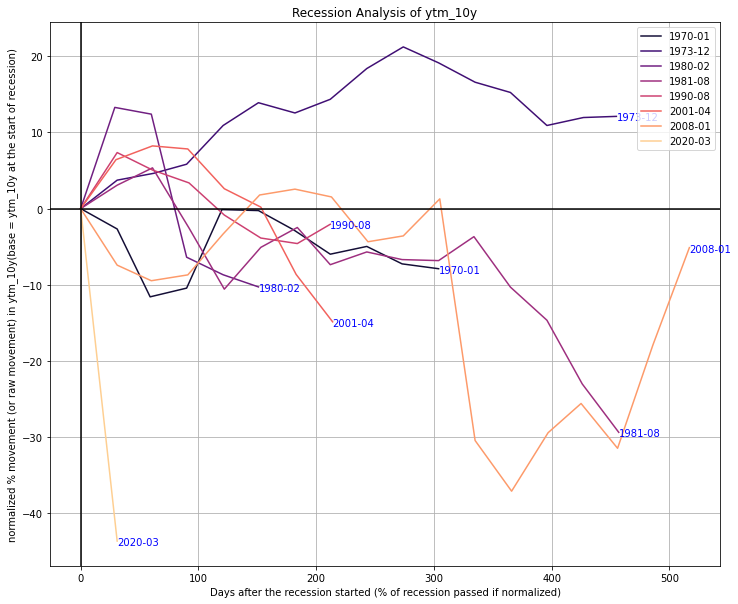

In [331]:
# 10 Years Treasury Yield
ytm_10y = fred.get_series('DGS10')
ytm_10y = pd.DataFrame(ytm_10y,columns=['ytm_10y']).dropna()

D = Recession_Analysis(ytm_10y, 'ytm_10y', normalize_move=True, normalize_days=False)

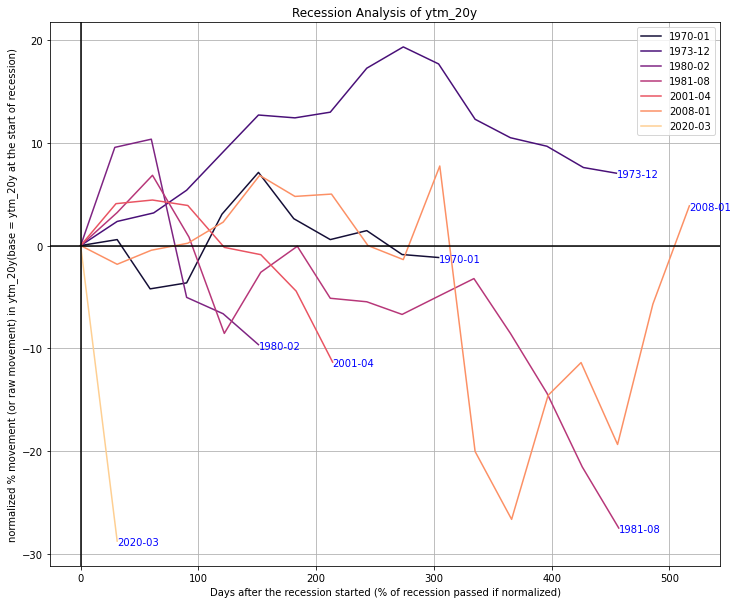

In [329]:
# 20 Years Treasury Yield
ytm_20y = fred.get_series('DGS20')
ytm_20y = pd.DataFrame(ytm_20y,columns=['ytm_20y']).dropna()

D = Recession_Analysis(ytm_20y, 'ytm_20y', normalize_move=True, normalize_days=False)

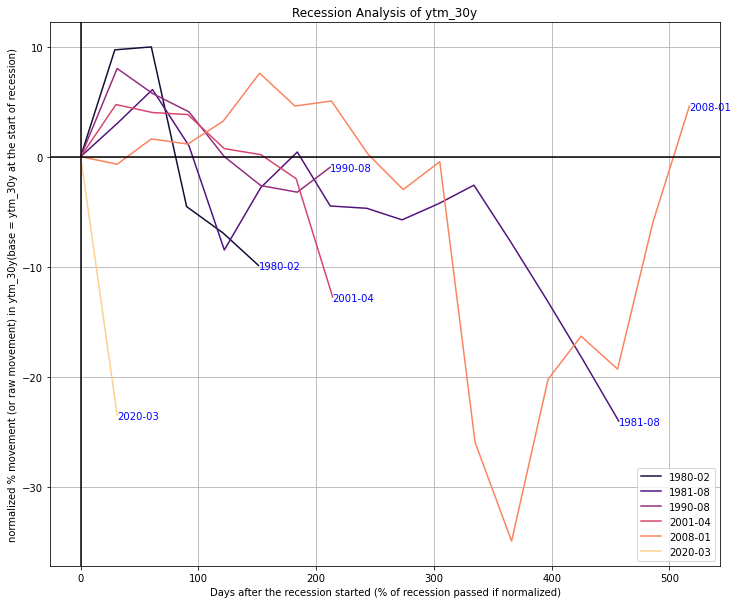

In [330]:
# 30 Years Treasury Yield
ytm_30y = fred.get_series('DGS30')
ytm_30y = pd.DataFrame(ytm_30y,columns=['ytm_30y']).dropna()

D = Recession_Analysis(ytm_30y, 'ytm_30y', normalize_move=True, normalize_days=False)

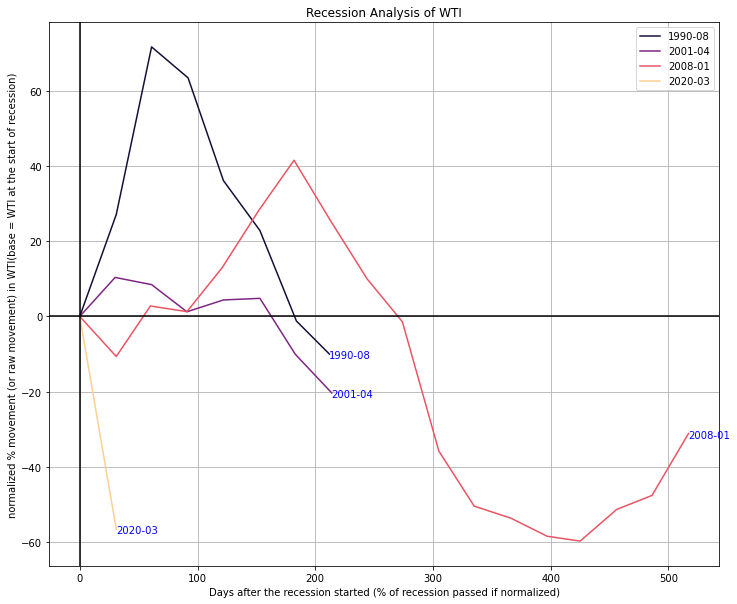

In [312]:
# WTI Oil Price
WTI = fred.get_series('DCOILWTICO')
WTI = pd.DataFrame(WTI,columns=['WTI']).dropna()

D = Recession_Analysis(WTI, 'WTI', normalize_move=True, normalize_days=False)

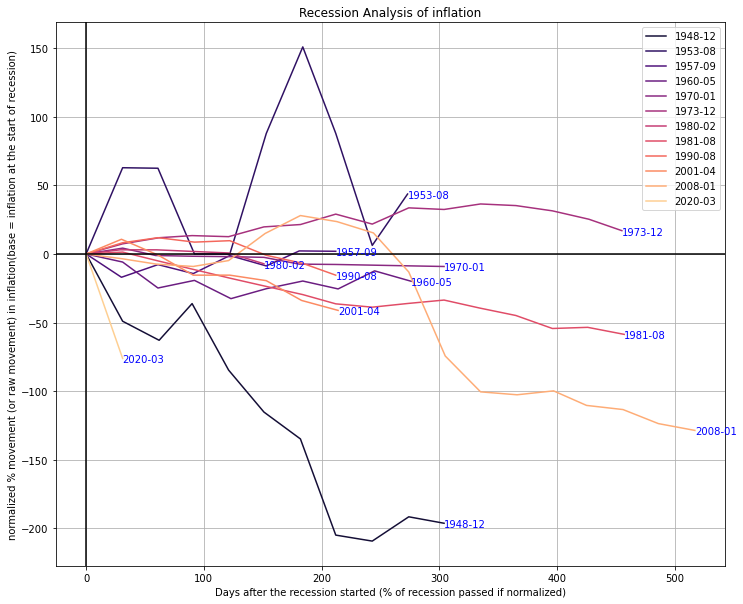

In [302]:
# Headline CPI inflation
CPI = fred.get_series('CPIAUCSL')
infl = CPI/CPI.shift(12) - 1
infl = pd.DataFrame(infl,columns=['inflation']).dropna()

D = Recession_Analysis(infl, 'inflation', normalize_move=True, normalize_days=False)